## Step 1: Direct Summation

In [1]:
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, and we usually call them N-body problems. Some typical examples are molecular dynamics, astrodynamics and electromagnetics. Their pairwise interactions can be expressed as:

$$\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \tag*{for $i=1,2,...,n$ }
\end{equation}$$

where subscript $i$,  $j$ respectively denotes *target* and *source*, $f_i$ can be a *potential* (or *force*) at target point $i$, $w_j$ is the *source weight*, $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles, and $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

Through this tutorial, a treecode algorithm is demonstated step by step to reduce the computation cost to $\mathcal{O} \left( n\log n \right)$ on a **gravitational N-body problem**.
In the first IPython Notebook, we will use the most straightforward way to calculate the gravitational potential at each target point. 

Assuming there are $n$ point mass particles in the 'galaxy', each can be treated as a target and a source to other particles. To begin with, let's generate a random location for each particle in the domain $x$, $y$, $z$ $\in$ $\left[ 0, 1 \right]$. Here we also assume that every particle has the same mass with a summation of 1. 

In [2]:
class Point():
    """The class for a point.
    
    Arguments:
        coords: a three-element list, containing the 3d coordinates of the point
        domain: the domain of random generated coordinates x,y,z, default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, coords=[], domain=1.0):
        if coords:
            assert len(coords) == 3, "the size of coords should be 3."
            self.x = coords[0]
            self.y = coords[1]
            self.z = coords[2]
        else:
            self.x = domain * numpy.random.random()
            self.y = domain * numpy.random.random()
            self.z = domain * numpy.random.random()
            
    # overload distance function
    def distance(self, other):
        return numpy.sqrt((self.x-other.x)**2 + (self.y-other.y)**2
                                          + (self.z-other.z)**2)

In [3]:
class Particle(Point):
    """The derived class for a particle, inheriting the base class "Point".
    
    Attributes:
        m: mass of the particle
        phi: the gravitational potential of the particle
    """
    
    def __init__(self, coords=[], domain=1.0, m=1.0):
        Point.__init__(self, coords, domain)
        self.m = m
        self.phi = 0.

The class *Particle* is a subclass of *Point* and we can check it by using the function `issubclass()`. Let's try it:

In [4]:
issubclass(Particle,Point)

True

Let's create our particles using our Particle class, and we store them in a list. 

In [5]:
n = 50
particles = [ Particle(m=1.0/n) for i in range(n) ]

Direction summation is the closest implementation to a physical problem, where each particle can "feel" the gravitational force due to others in the system. Therefore, the number of interactions scales as $\mathcal{O} \left(n^2 \right)$. The potential $\Phi_i$ at a target point $i$ in the gravitational field can be expressed as:

$$\begin{equation}
\Phi_i = \sum_{\substack{j=0\\ j \neq i}}^n{\frac{m_j}{r_{ij}}}
\end{equation}$$

where $m_j$ denotes the mass of source point $j$, and $r_{ij}$ is the distance between target point $i$ and source point $j$.

In [6]:
def direct_sum(particles):
    """Calculate the gravitational potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m/r

Let's run it.

In [7]:
direct_sum(particles)

The output is an array of the gravitational potential at each target point. Later we will use the direct summation result as the accurate solution when compared to the result of using multipole expansion and the final treecode.

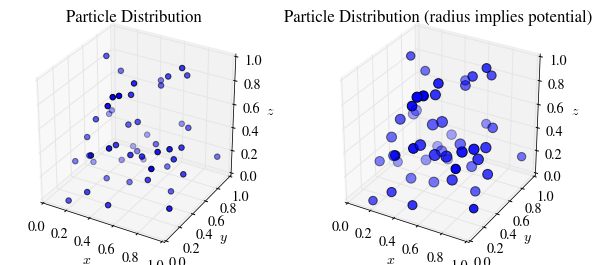

In [8]:
# plot spatial particle distribution
fig = pyplot.figure(figsize=(10,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter([particle.x for particle in particles], 
           [particle.y for particle in particles], 
           [particle.z for particle in particles], s=30, c='b')
ax.set_xlim3d(0,1)
ax.set_ylim3d(0,1)
ax.set_zlim3d(0,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 50   # scale for dot size in scatter plot
ax.scatter([particle.x for particle in particles], 
           [particle.y for particle in particles], 
           [particle.z for particle in particles],
           s=numpy.array([particle.phi for particle in particles])*scale, c='b')
ax.set_xlim3d(0,1)
ax.set_ylim3d(0,1)
ax.set_zlim3d(0,1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Particle Distribution (radius implies potential)');

Now let's try a magic function [**%timeit**](https://docs.python.org/2/library/timeit.html) to evaluate the computation time of direct summation method. (Try **%lsmagic** to see a list of line magics and cell magics)

In [9]:
%timeit direct_sum(particles)

100 loops, best of 3: 9.91 ms per loop


The output shows the average time taken by the best 3 loop run by **timeit** . When we dive into treecode, we will use this magic funtion to achieve the benchmarks. In the code, we use double loops to evaluate the interaction of each pair. We usually refer the direct summation function as the **Particle-to-Particle** or **P2P** kernal. 

##### Reference

1. R. Yokota, 12 Steps to a Fast Multipole Method on GPUs, Pan-American Advanced Studies Institute, Valparaiso, Chile, 3-14 January, 2011.
2. Raykar, V. C., "[A short primer on the fast multipole method: FMM tutorial](http://www.umiacs.umd.edu/labs/cvl/pirl/vikas/publications/FMM_tutorial.pdf),", University of Maryland, College Park, Apr. 8, 2006.

In [10]:
# loading style sheet
from IPython.core.display import HTML
def css_styling():
    styles = open('./style/fmmstyle.css', 'r').read()
    return HTML(styles)
css_styling()